# 559A Final Project - BEV

This project uses the NuScenes v1.0-mini dataset to construct a bird’s-eye view (BEV) of the vehicle surroundings and perform detection and annotation of vehicles and pedestrians within the BEV. In this dataset, each vehicle is equipped with six fisheye cameras, and the intrinsic and extrinsic parameters of the cameras are provided.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import torch
import concurrent.futures
import os
from ultralytics import YOLO
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Load NuScenes dataset

In [93]:
nusc = NuScenes(version='v1.0-mini', dataroot='v1.0-mini', verbose=True)
camera_channels = [
'CAM_FRONT',
'CAM_FRONT_LEFT',
'CAM_FRONT_RIGHT',
'CAM_BACK',
'CAM_BACK_LEFT',
'CAM_BACK_RIGHT'
]
print(f'use cuda: {torch.cuda.is_available()}')

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.317 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.
use cuda: True


# Create one camera projection image
- Initialize BEV canvas and weight map based on the given physical size and resolution.

- Load image, camera intrinsics, and extrinsics from the NuScenes dataset.

- Build ray directions from each image pixel in camera space and transform them into ego (vehicle) coordinate space.

- Filter rays that point toward the ground (negative Z direction).

- Compute ground intersection points (where rays hit the Z=0 plane).

- Filter points that fall outside the defined BEV area.

- Map valid ground points to BEV image coordinates.

- Use weights (based on distance) to keep the most relevant pixels (closer ones) in case of overlaps.

- Update the BEV image with corresponding pixel colors from the original image.

In [94]:
def create_bev_view(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2', cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04, ray_filter=-0.1):
    """
    Use Torch acceleration to create a bird's-eye view
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    - bev_width: bev view width (meters)
    - bev_length: bev view length (meters)
    - resolution: resolution, the actual distance per pixel (meters/pixel)
    
    Returns:
    - bird_eye_view: bev view image
    - img: original image
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initial variables
    # BEV image size
    bev_height = int(bev_length / resolution)
    bev_width_pixels = int(bev_width / resolution)
    # Bev image and weight map
    bird_eye_view = torch.zeros((bev_height, bev_width_pixels, 4), dtype=torch.uint8, device=device)
    weight_map = torch.zeros((bev_height, bev_width_pixels), dtype=torch.float32, device=device)
    # Get sample
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    # Camera intrinsic matrix
    K = np.array(cs_record['camera_intrinsic'])
    K_tensor = torch.from_numpy(K).float().to(device)
    img_path = nusc.get_sample_data_path(cam_token)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    img_tensor = torch.from_numpy(img).to(device)
    img_height, img_width = img_tensor.shape[:2]
    # Camera extrinsic 
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    cam_to_ego_rotation = Quaternion(cs_record['rotation']).rotation_matrix
    cam_to_ego_translation = np.array(cs_record['translation'])
    
    # Camera coordinate to vehical coordinate
    cam_to_ego = np.eye(4)
    cam_to_ego[:3, :3] = cam_to_ego_rotation
    cam_to_ego[:3, 3] = cam_to_ego_translation
    cam_to_ego_tensor = torch.from_numpy(cam_to_ego).float().to(device)
    cam_pos_ego = cam_to_ego_translation
    cam_pos_ego_tensor = torch.from_numpy(cam_pos_ego).float().to(device)
    
    # Place the origin ego system at the center of the image
    ego_center_x = bev_width_pixels // 2
    ego_center_y = bev_height // 2
    
    # Create grid coordinates
    v_indices, u_indices = torch.meshgrid(
        torch.arange(0, img_height, device=device),
        torch.arange(0, img_width, device=device),
        indexing='ij'
    )
    v_indices = v_indices.flatten()
    u_indices = u_indices.flatten()
    
    # Normalization
    x_norm = (u_indices - K_tensor[0, 2]) / K_tensor[0, 0]
    y_norm = (v_indices - K_tensor[1, 2]) / K_tensor[1, 1]
    
    # Ray direction in camera coordinate system
    ray_camera = torch.stack([x_norm, y_norm, torch.ones_like(x_norm)], dim=1)
    
    # Convert to ray direction in ego coordinate system
    ray_ego = torch.matmul(cam_to_ego_tensor[:3, :3], ray_camera.unsqueeze(-1)).squeeze(-1)
    ray_norm = torch.norm(ray_ego, dim=1, keepdim=True)
    ray_ego = ray_ego / ray_norm
    
    # Filter out rays pointing upward or parallel to the ground
    valid_rays = ray_ego[:, 2] < ray_filter
    

    # Keep valid rays(pointing to the ground)
    valid_u = u_indices[valid_rays]
    valid_v = v_indices[valid_rays]
    valid_ray_ego = ray_ego[valid_rays]
    
    # Calculate the intersection of the ray with the ground(Z=0 plane)
    t = -cam_pos_ego_tensor[2] / valid_ray_ego[:, 2]
    ground_point_ego = cam_pos_ego_tensor.unsqueeze(0) + t.unsqueeze(1) * valid_ray_ego
    
    # Extract x,y coordinates in ego coordinate system
    x_ego, y_ego = ground_point_ego[:, 0], ground_point_ego[:, 1]
    
    # Filter condition in ego coordinate system
    half_length = bev_length / 2
    half_width = bev_width / 2
    
    # Ensure the point is within the BEV range
    in_range = (x_ego >= -half_length) & (x_ego <= half_length) & (y_ego >= -half_width) & (y_ego <= half_width)
    
    # Keep the points within the range
    x_ego = x_ego[in_range]
    y_ego = y_ego[in_range]
    valid_u = valid_u[in_range]
    valid_v = valid_v[in_range]
    
    # Calculate the distance to the vehicle center, for weight calculation
    distance = torch.sqrt(x_ego**2 + y_ego**2)
    weight = torch.exp(-distance / 20.0)
    
    # Map the points in ego coordinate system to the BEV image coordinates
    i = ego_center_y - (x_ego / resolution).long()  # x_ego positive (forward) corresponds to the upper part of the image
    j = ego_center_x - (y_ego / resolution).long()  # y_ego positive (left) corresponds to the left half of the image
    
    # Ensure the coordinates are within the image range
    valid_coords = (i >= 0) & (i < bev_height) & (j >= 0) & (j < bev_width_pixels)

    # Keep the valid coordinates
    i = i[valid_coords]
    j = j[valid_coords]
    weight = weight[valid_coords]
    valid_u = valid_u[valid_coords]
    valid_v = valid_v[valid_coords]
    
    # Create indices for atomic operations
    indices = i * bev_width_pixels + j
    
    # Get the current weight and image
    current_weights = weight_map.view(-1)[indices]
    
    # Find the pixels with larger weights
    better_pixels = weight > current_weights

    # Filter out the pixels with larger weights
    filtered_weight = weight[better_pixels]
    filtered_u = valid_u[better_pixels]
    filtered_v = valid_v[better_pixels]
    filtered_indices = indices[better_pixels]
    
    # Update the weights
    weight_map.view(-1)[filtered_indices] = filtered_weight
    
    # Get the pixel colors
    pixel_colors = img_tensor[filtered_v, filtered_u]
    
    # Update the BEV imageWW
    bird_eye_view.view(-1, 4)[filtered_indices, :3] = pixel_colors[:, :3]
    bird_eye_view.view(-1, 4)[filtered_indices, 3] = 255

    bird_eye_view_np = bird_eye_view.cpu().numpy()
    
    return bird_eye_view_np, img

## Visualize

In [95]:
def visualize_bev_view(bev, original_img, flag_save=False, save_path='images/bev_only.png'):
    """
    Visualize the bev view transformation result
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    """
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Projection Image')
    plt.imshow(bev)
    plt.axis('off')
    
    plt.tight_layout()
    
    if flag_save:
        plt.savefig(save_path, transparent=False)
        
    plt.show()

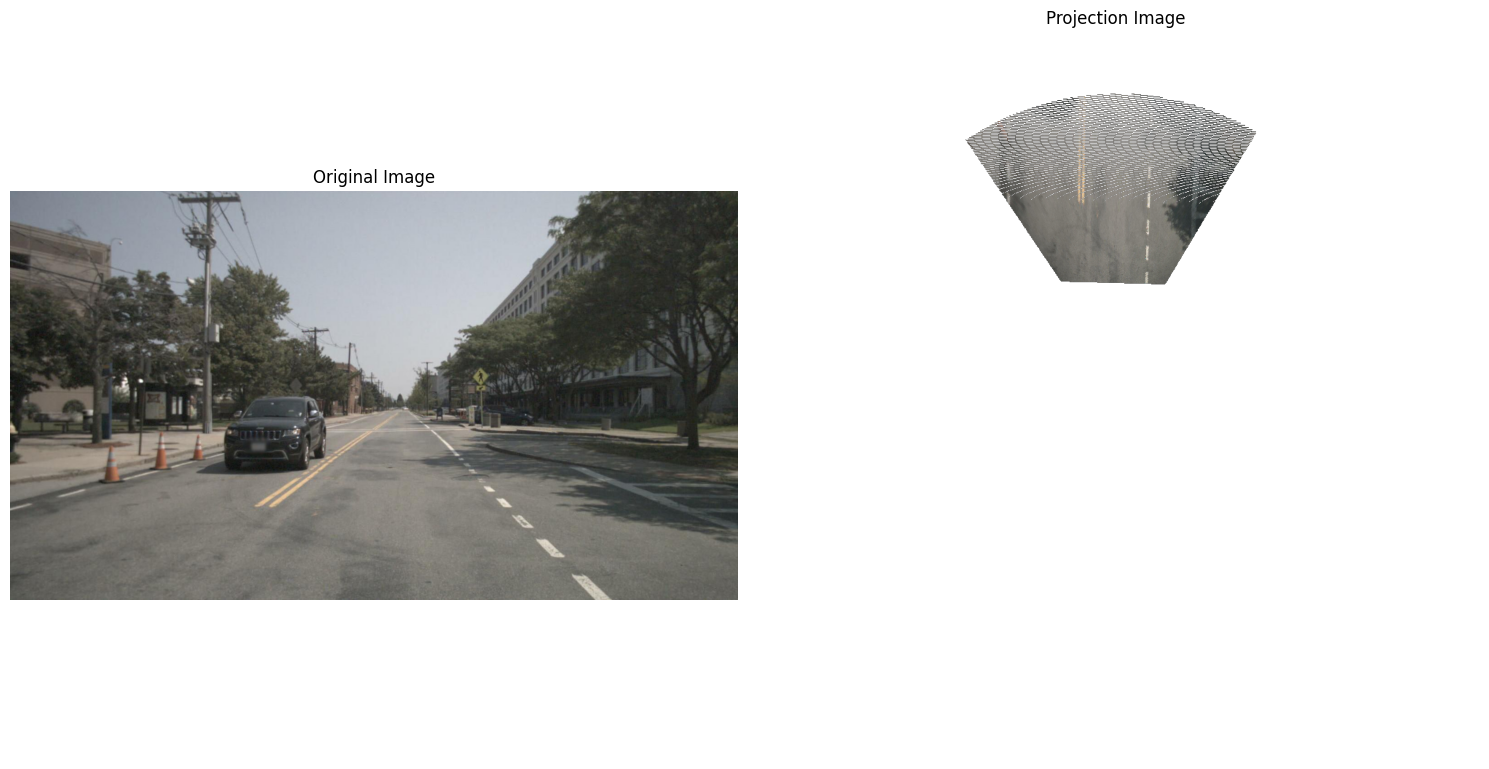

In [96]:
bev, img = create_bev_view(sample_token=nusc.sample[159]['token'])
visualize_bev_view(bev, img, flag_save=True, save_path='images/bev_only.png')

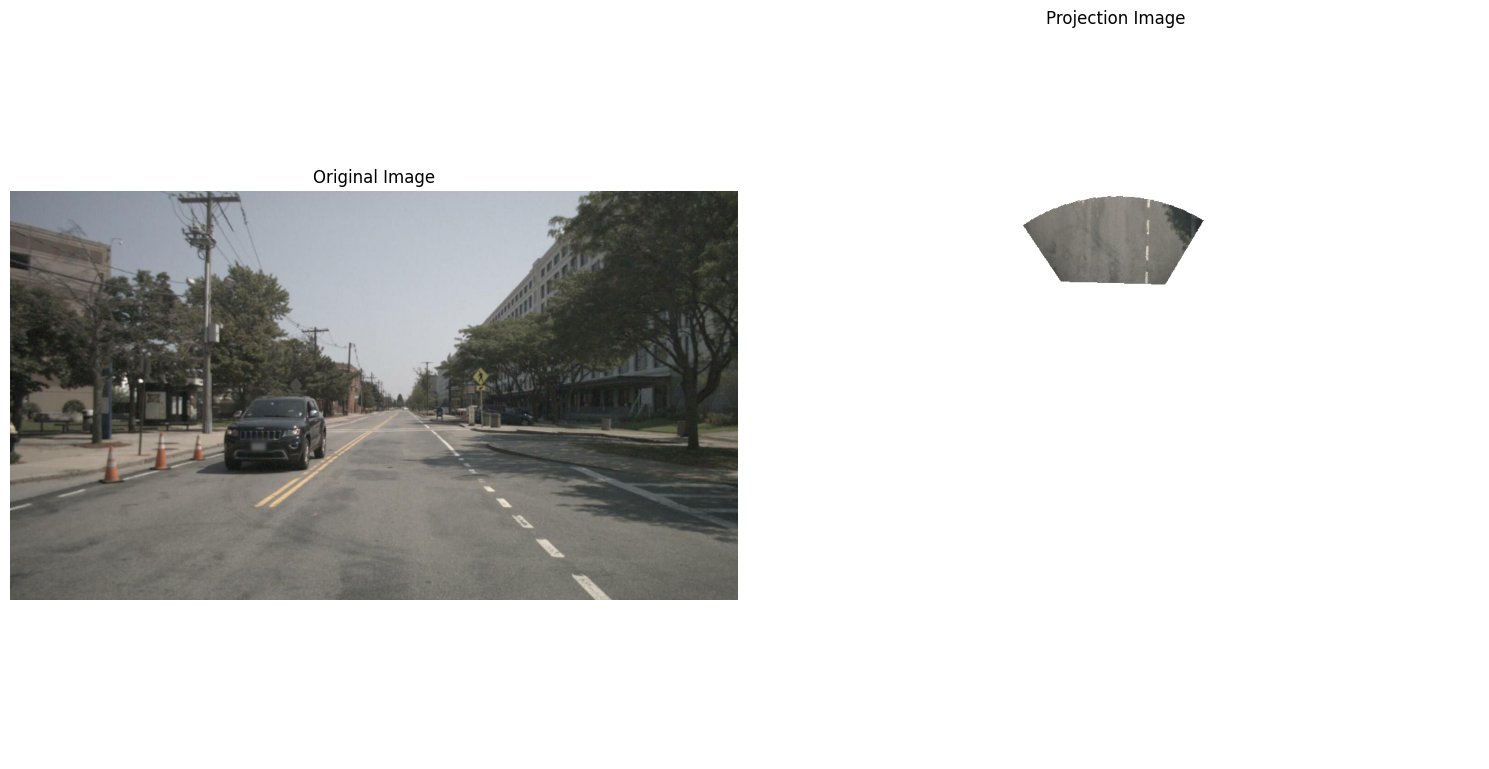

In [97]:
bev, img = create_bev_view(sample_token=nusc.sample[159]['token'], ray_filter=-0.16)
visualize_bev_view(bev, img)

In the generated BEV image, white artifacts may appear in distant regions. This is not due to incorrect projections, but rather because **some BEV pixels are not hit by any projected rays** — especially those located far from the camera. These empty pixels remain uninitialized or partially filled (e.g., with default RGB values and alpha = 255), which leads to white patches in the output image.

If I want to avoid this, I can use a stricter threshold:
```python
# ray_ego means the direction of the ray that starts from the camera's optical center and passes through a pixel in the image (in the vehicle's ego coordinate system)
valid_rays = ray_ego[:, 2] < -0.16
```
But this will reduce the overall projection range and causes the BEV to cover a smaller area. After some testing, I decided to set the threshold to:
```python
valid_rays = ray_ego[:, 2] < -0.1
```
Then I add a smoothing operation to the BEV image to fill small gaps and softens transitions, effectively suppressing white artifacts without sacrificing BEV coverage.


## Smoothing
- Use morphological closing operation to remove small holes
- Use Gaussian blur to smooth edges(optional)

In [98]:
def smooth_bev_image(image, cam_channel='CAM_FRONT', flag_blur=False):
    """
    Apply smoothing operations to the BEV image

    Args:
    - image: BEV image to smooth
    - resolution: resolution in meters/pixel

    Returns:
    - smoothed_image: processed image
    """
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing operation
    if cam_channel == 'CAM_BACK':
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
    else:
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Apply Gaussian blur
    if flag_blur:
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    return image

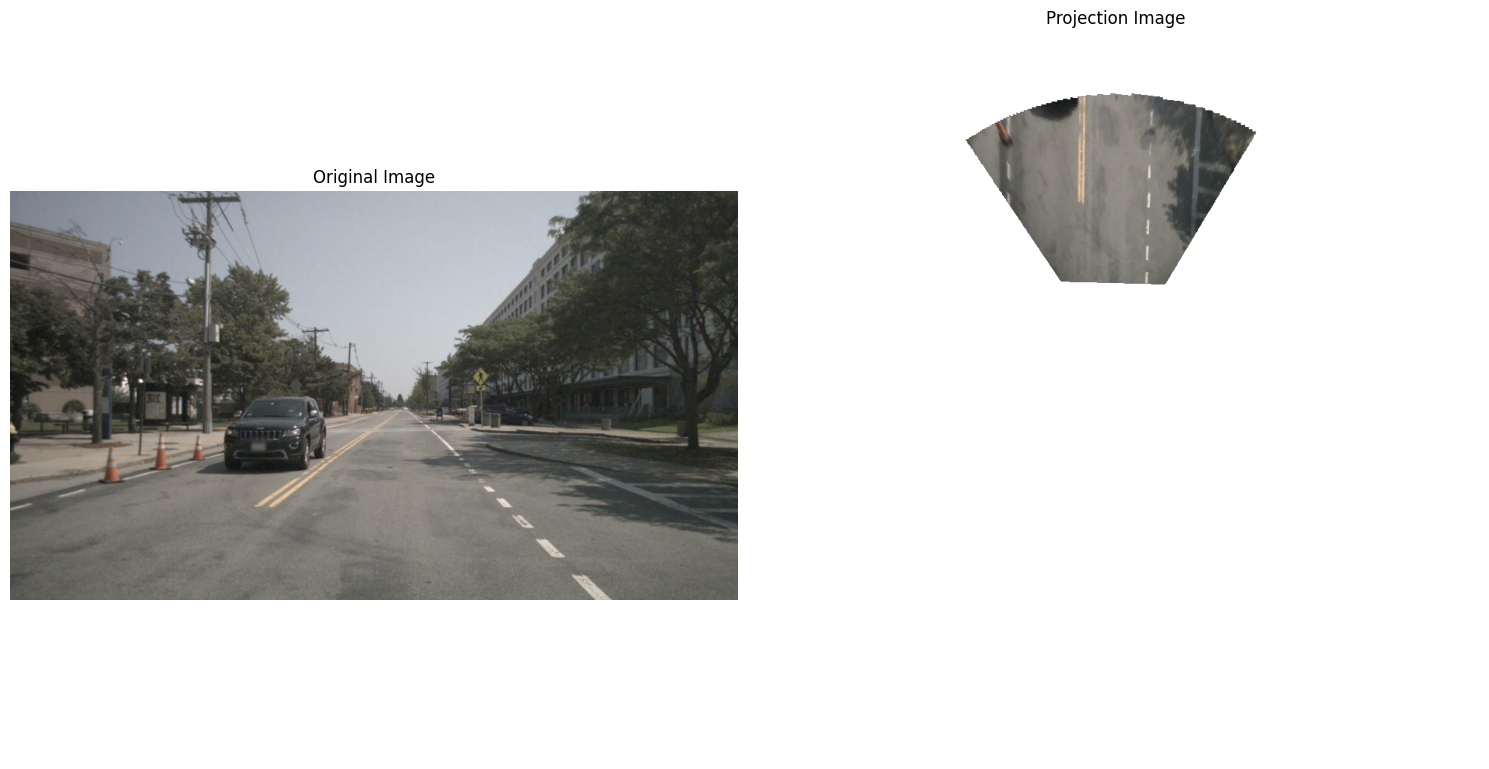

In [99]:
bev, img = create_bev_view(sample_token=nusc.sample[159]['token'], ray_filter=-0.1)
bev = smooth_bev_image(bev, cam_channel='CAM_FRONT')
visualize_bev_view(bev=bev, original_img=img, flag_save=True, save_path='images/bev_smooth.png')

## Detect vehicles and pedestrians in the camera view
Use YOLOv8 to detect vehicles and pedestrians in the camera view


0: 384x640 3 persons, 4 cars, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


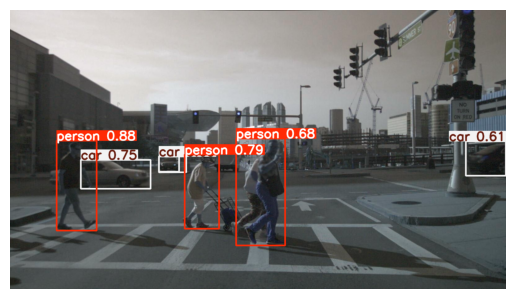

In [100]:
model = YOLO('models/yolov8n.pt')
my_sample = nusc.sample[100]
img = cv2.imread(nusc.get_sample_data_path(my_sample['data']['CAM_FRONT']))
results = model(img, conf=0.3, classes=[0, 2, 3, 5, 7]) # person, car, motorcycle, bus, truck 
plt.imshow(results[0].plot())
plt.axis('off')
plt.savefig('images/detection_result.png', transparent=False)
plt.show()

## Project detections results into a point cloud in BEV

- Use the position of the bottom center point of the bounding box to project the detections results into a point cloud in BEV
- Calcuate distance from bottom center point of the bounding box to camera optical center

In [101]:
def project_detections_to_bev(results, K, cam_to_ego, bev_width_pixels=1000, bev_length_pixels=1000, resolution=0.04):
    """
    Project detections from image coordinates to BEV coordinates
    
    Args:
    - results: YOLOv8 detection results
    - K: Camera intrinsic matrix
    - cam_to_ego: Camera to ego coordinate transformation matrix
    - img_dims: Image dimensions (width, height)
    - bev_width_pixels: BEV width in pixels
    - bev_length_pixels: BEV length in pixels
    - resolution: Resolution (meters/pixel)
    
    Returns:
    - detection_points: Detection points in BEV
    """   
    # BEV center point
    ego_center_x = bev_width_pixels // 2
    ego_center_y = bev_length_pixels // 2
    # Store projected detection results
    detection_points = []
    
    boxes = results[0].boxes
    for _, box in enumerate(boxes):
        # Get bottom center point of bounding box
        x1, _, x2, y2 = box.xyxy[0].cpu().numpy()
        bottom_center_x = (x1 + x2) / 2
        bottom_center_y = y2
        
        # Normalize
        x_norm = (bottom_center_x - K[0, 2]) / K[0, 0]
        y_norm = (bottom_center_y - K[1, 2]) / K[1, 1]
        
        # Ray direction in camera coordinate system
        ray_camera = np.array([x_norm, y_norm, 1.0])
        
        # Convert to ego coordinate system
        ray_ego = cam_to_ego[:3, :3] @ ray_camera
        ray_ego = ray_ego / np.linalg.norm(ray_ego)
        
        # Filter out rays pointing upward or parallel to the ground
        if ray_ego[2] >= -0.1:
            continue
        
        # Calculate intersection with ground (Z=0 plane)
        cam_pos_ego = cam_to_ego[:3, 3]
        t = -cam_pos_ego[2] / ray_ego[2]
        ground_point_ego = cam_pos_ego + t * ray_ego

        # Extract x,y coordinates in ego coordinate system
        x_ego, y_ego = ground_point_ego[0], ground_point_ego[1]
        
        # Convert to BEV coordinates
        bev_x = ego_center_x - int(y_ego / resolution)
        bev_y = ego_center_y - int(x_ego / resolution)
        
        # Make sure the projected point is within the BEV range
        if 0 <= bev_x < bev_width_pixels and 0 <= bev_y < bev_length_pixels:
            cls_id = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            cls_name = results[0].names[cls_id]
            
            detection_points.append({
                'bev_x': bev_x,
                'bev_y': bev_y,
                'class': cls_name,
                'confidence': conf,
                'distance': t
            })
    
    return detection_points

In [102]:
sample = nusc.get('sample', nusc.sample[100]['token'])
cam_token = sample['data']['CAM_FRONT']
cam_data = nusc.get('sample_data', cam_token)
cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
K = np.array(cs_record['camera_intrinsic'])
cam_to_ego_rotation = Quaternion(cs_record['rotation']).rotation_matrix
cam_to_ego_translation = np.array(cs_record['translation'])
cam_to_ego = np.eye(4)
cam_to_ego[:3, :3] = cam_to_ego_rotation
cam_to_ego[:3, 3] = cam_to_ego_translation

detection_points = project_detections_to_bev(results=results, K=K, cam_to_ego=cam_to_ego)
print(detection_points)

[{'bev_x': 395, 'bev_y': 248, 'class': 'person', 'confidence': 0.8752647042274475, 'distance': 9.482810453035475}, {'bev_x': 463, 'bev_y': 247, 'class': 'person', 'confidence': 0.7891141176223755, 'distance': 8.69411008704852}, {'bev_x': 496, 'bev_y': 289, 'class': 'person', 'confidence': 0.6843491792678833, 'distance': 6.904914814609799}]


### Visualize the point cloud in BEV

In [135]:
def visualize_bev_with_detections(bev_img, detection_img, projected_boxes, flag_save=False, save_path='images/bev_with_detections.png'):
    """
    Visualize the BEV image with detection results
    
    Args:
    - bev_img: BEV image
    - original_img: Original image
    - detection_img: Image with detection boxes
    - projected_boxes: Projected detection boxes to BEV
    """
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Detection result')
    plt.imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('BEV with Detection result')
    bev_with_detections = bev_img.copy()

    color_map = {
        'person': (255, 0, 0, 255),   # Red
        'car': (0, 255, 0, 255),      # Green
        'truck': (0, 0, 255, 255),    # Blue
        'bus': (255, 255, 0, 255),    # Yellow
        'motorcycle': (255, 0, 255, 255), # Magenta
        'bicycle': (0, 255, 255, 255),    # Cyan
    }
    
    # Detection boxes
    for box in projected_boxes:
        x, y = box['bev_x'], box['bev_y']
        cls = box['class']
        
        # Select color based on class
        color = color_map.get(cls)
        
        # Draw circle marker on BEV image
        cv2.circle(bev_with_detections, (x, y), 7, color, -1)
        
        # Add class label and distance
        label_text = f"{cls}"
        cv2.putText(bev_with_detections, label_text, (x + 10, y - 7), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color[:3], 1, cv2.LINE_AA)
        if 'distance' in box:
            distance = box['distance']
            dist_text = f"{distance:.1f}m"
            # Position distance text below the class label
            cv2.putText(bev_with_detections, dist_text, (x + 10, y + 7), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color[:3], 1, cv2.LINE_AA)
    
    plt.imshow(bev_with_detections)
    plt.axis('off')
    if flag_save:
        plt.savefig(save_path, transparent=False)
    plt.show()

In [104]:
def run_detection_on_sample(sample_token, cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04, conf_thresh=0.3):
    """
    Run detection on a specified sample and generate BEV view
    
    Args:
    - sample_token: Sample token
    - cam_channel: Camera channel
    - bev_width: BEV view width (meters)
    - bev_length: BEV view length (meters)
    - resolution: Resolution (meters/pixel)
    - conf_thresh: Detection confidence threshold
    
    Returns:
    - bev_img: BEV image
    - original_img: Original image
    - detection_img: Image with detection boxes
    - projected_boxes: Projected detection boxes to BEV
    """
    
    # Get sample
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    
    # Get camera parameters
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    K = np.array(cs_record['camera_intrinsic'])
    cam_to_ego_rotation = Quaternion(cs_record['rotation']).rotation_matrix
    cam_to_ego_translation = np.array(cs_record['translation'])
    
    # Camera to ego coordinate transformation
    cam_to_ego = np.eye(4)
    cam_to_ego[:3, :3] = cam_to_ego_rotation
    cam_to_ego[:3, 3] = cam_to_ego_translation
    
    # Read image
    img_path = nusc.get_sample_data_path(cam_token)
    original_img = cv2.imread(img_path)
    
    # Get image size
    bev_length_pixels = int(bev_length / resolution)
    bev_width_pixels = int(bev_width / resolution)
    
    # Get BEV image
    bev_img, _ = create_bev_view(sample_token, cam_channel, bev_width, bev_length, resolution)
    # Smooth BEV image
    bev_img = smooth_bev_image(bev_img, cam_channel)
    
    # Detection
    model = YOLO('models/yolov8n.pt')
    results = model(original_img, conf=conf_thresh, classes=[0, 2, 3, 5, 7]) # person, car, motorcycle, bus, truck
    detection_img = results[0].plot() 
    
    # Project detection results to BEV view
    projected_boxes = project_detections_to_bev(results, K, cam_to_ego, bev_width_pixels, bev_length_pixels, resolution)
    
    return bev_img, original_img, detection_img, projected_boxes


0: 384x640 3 persons, 4 cars, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


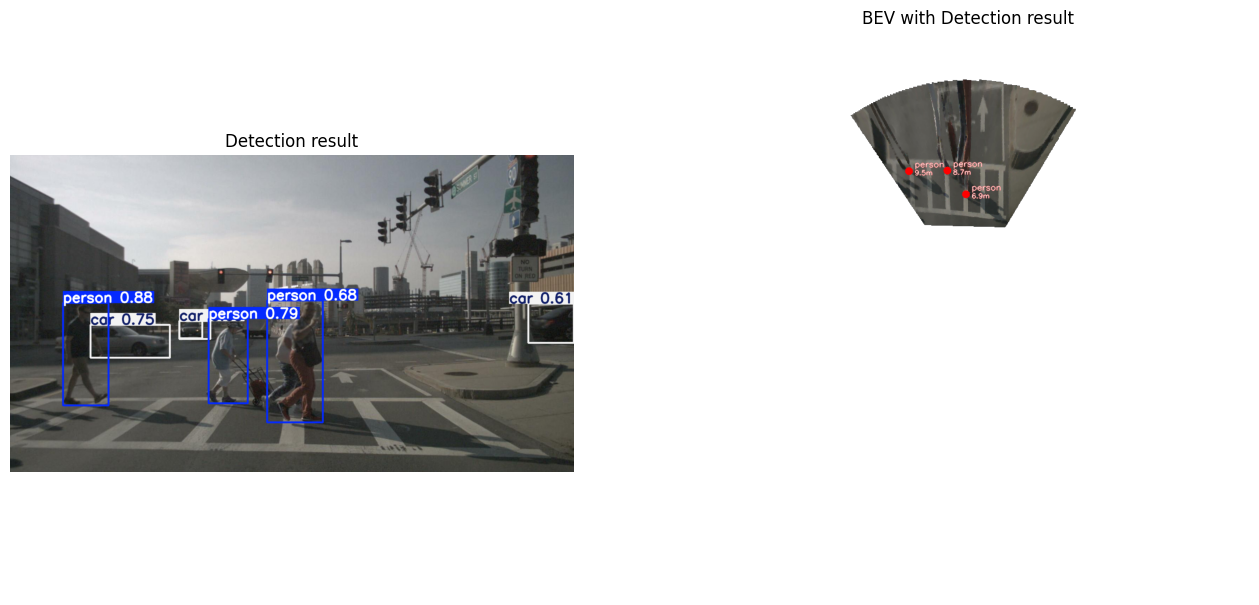

In [136]:
bev_img, original_img, detection_img, projected_boxes = run_detection_on_sample(
        sample_token=nusc.sample[100]['token'],
        cam_channel='CAM_FRONT',
        conf_thresh=0.3
    )

visualize_bev_with_detections(bev_img, detection_img, projected_boxes, flag_save=True)

## Get the projection images of all six cameras(build 360 degree BEV)

### Set multiple threads to process all cameras at the same time
- Create 6 threads to process 6 cameras at the same time
- Use thread pool to parallelly process

In [106]:
def process_camera_worker(params):
    """
    Worker function to process a single camera's BEV projection and gather its info.
    Combines logic previously in get_camera_info and process_single_camera.
    
    Args:
    - params: dictionary containing processing parameters:
        - sample_token: sample token
        - cam_channel: camera channel
        - bev_width: BEV width (meters)
        - bev_length: BEV length (meters)
        - resolution: resolution (meters/pixel)
    
    Returns:
    - camera_data: dictionary containing camera information and processing results
    """
    sample_token = params['sample_token']
    cam_channel = params['cam_channel']
    bev_width = params['bev_width']
    bev_length = params['bev_length']
    resolution = params['resolution']

    # Initial sample data
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    intrinsic = np.array(cs_record['camera_intrinsic'])
    translation = np.array(cs_record['translation'])
    rotation_quat = Quaternion(cs_record['rotation'])
    rotation_matrix = rotation_quat.rotation_matrix
    camera_info = {
        'translation': translation,
        'rotation': rotation_matrix,
        'intrinsic': intrinsic
    }

    # Run detection and BEV projection
    bev, _, _, detection_points = run_detection_on_sample(
        sample_token=sample_token, 
        cam_channel=cam_channel, 
        bev_width=bev_width, 
        bev_length=bev_length, 
        resolution=resolution
    )

    # Prepare the result dictionary
    camera_data = {
        'cam_channel': cam_channel,
        'bev': bev,
        'camera_info': camera_info,
        'detection_points': detection_points
    }
    return camera_data

def process_all_cameras_parallel(sample_token, bev_width=40, bev_length=40, resolution=0.04, max_workers=6):
    """
    Parallelly process the BEV projection of all cameras
    
    Args:
    - sample_token: sample token
    - bev_width: BEV width (meters)
    - bev_length: BEV length (meters)
    - resolution: resolution (meters/pixel)
    - max_workers: maximum number of threads
    
    Returns:
    - bev_results: dictionary containing all camera BEV results
    """
    bev_results = {}
    
    # Prepare thread task parameters
    tasks = []
    for cam_channel in camera_channels:
        params = {
            'sample_token': sample_token,
            'cam_channel': cam_channel,
            'bev_width': bev_width,
            'bev_length': bev_length,
            'resolution': resolution
        }
        tasks.append(params)
        
    # Use thread pool to parallelly process
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_camera_worker, params) for params in tasks]
        
        # Collect results
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            cam_channel = result['cam_channel']

            bev_results[cam_channel] = {
                'bev': result['bev'],
                'camera_info': result['camera_info'],
                'detection_points': result['detection_points']
            }
    
    return bev_results







0: 384x640 1 car, 1 truck, 40.5ms
Speed: 1.2ms preprocess, 40.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 cars, 43.4ms
Speed: 1.1ms preprocess, 43.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 4 cars, 1 bus, 44.7ms
Speed: 1.0ms preprocess, 44.7ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 9 cars, 47.8ms
Speed: 1.1ms preprocess, 47.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 cars, 47.9ms
Speed: 1.0ms preprocess, 47.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 (no detections), 49.6ms
Speed: 1.0ms preprocess, 49.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


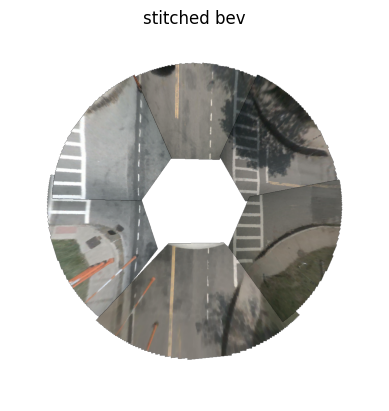

In [107]:
bev_results = process_all_cameras_parallel(nusc.sample[159]['token'])
for channel, cam_data in bev_results.items():
    plt.imshow(cam_data['bev'])
    plt.axis('off')
plt.title('stitched bev')
plt.savefig('images/bev_no_fusion.png', transparent=False)
plt.show()

## Optimize the BEV stitching process


### Position-Based Multi-Camera BEV Image Stitching via Priority-Weighted Blending
- Set a predefined priority level for each camera based on its viewpoint (e.g., front > back > sides).
- For each valid pixel in a BEV image, compute its distance to the edge of the foreground area using distance transform.
- Calculate a weight for each pixel based on both the camera's priority and its distance from the edge (center pixels are favored).
- Normalize the weights across all cameras for each pixel and blend the pixel values accordingly to generate the final stitched BEV image.

In [108]:
def position_based_stitch_bev_images(bev_results):
    """
    Assemble multiple BEV images based on camera position information
    
    Args:
    - bev_results: dictionary containing all camera BEV results
    - resolution: resolution (meters/pixel)
    
    Returns:
    - stitched_bev: stitched BEV image
    """
    
    # Initialize variables
    bev_height, bev_width_pixels = bev_results[list(bev_results.keys())[0]]['bev'].shape[:2]
    stitched_bev = np.zeros((bev_height, bev_width_pixels, 4), dtype=np.uint8)
    camera_contributions = np.zeros((bev_height, bev_width_pixels, len(bev_results), 4), dtype=np.float32)
    camera_weights = np.zeros((bev_height, bev_width_pixels, len(bev_results)), dtype=np.float32)
    camera_positions = {}
    
    # Priority order: front camera > back camera > side front camera > side back camera
    camera_priority = {
        'CAM_FRONT': 1,
        'CAM_FRONT_LEFT': 3,
        'CAM_FRONT_RIGHT': 3,
        'CAM_BACK': 2,
        'CAM_BACK_LEFT': 4,
        'CAM_BACK_RIGHT': 4
    }
    
    # Collect contributions from each camera
    for i, (cam_channel, result) in enumerate(bev_results.items()):
        # Extract camera information and BEV image
        bev = result['bev'].astype(np.float32)
        camera_info = result['camera_info']
        translation = camera_info['translation']
        # Position of the camera in the ego coordinate system
        camera_positions[cam_channel] = translation
        
        # Collect valid pixels
        valid_pixels = bev[:, :, 3] > 0    
        if not np.any(valid_pixels):
            continue
            
        base_priority = camera_priority.get(cam_channel)
        
        # Collect coordinates of valid pixels
        y_indices, x_indices = np.where(valid_pixels)
        
        # Valid pixels
        mask = np.zeros((bev_height, bev_width_pixels), dtype=np.uint8)
        mask[y_indices, x_indices] = 1
        
        # Distance from each pixel to the edge
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        # Normalize
        max_dist = np.max(dist_transform) if np.max(dist_transform) > 0 else 1.0
        dist_transform = dist_transform / max_dist
        
        # Calculate contribution for each pixel
        for j in range(len(y_indices)):
            y, x = y_indices[j], x_indices[j]
            
            # Calculate weight
            edge_weight = dist_transform[y, x]
            pixel_weight = base_priority * (1.0 - 0.3 * edge_weight)
            pixel_weight = 1 / pixel_weight
            
            # Store contribution and weight
            camera_contributions[y, x, i, :] = bev[y, x, :]
            camera_weights[y, x, i] = pixel_weight
    
    # Merge contributions from all cameras
    for y in range(bev_height):
        for x in range(bev_width_pixels):
            pixel_weights = camera_weights[y, x, :]
            
            if np.sum(pixel_weights) == 0:
                continue
            # If only one camera has contribution then use it
            non_zero_indices = np.nonzero(pixel_weights)[0]
            if len(non_zero_indices) == 1:
                i = non_zero_indices[0]
                stitched_bev[y, x, :] = camera_contributions[y, x, i, :].astype(np.uint8)
                continue
            
            pixel_weights = pixel_weights / np.sum(pixel_weights)
            # Merge contributions
            blended_pixel = np.zeros(4, dtype=np.float32)
            for i in range(len(bev_results)):
                if pixel_weights[i] > 0:
                    blended_pixel += pixel_weights[i] * camera_contributions[y, x, i, :]
            if blended_pixel[3] > 0:
                stitched_bev[y, x, :] = blended_pixel.astype(np.uint8)
            else:
                stitched_bev[y, x, :] = blended_pixel.astype(np.uint8)
    
    return stitched_bev

(-0.5, 999.5, 999.5, -0.5)

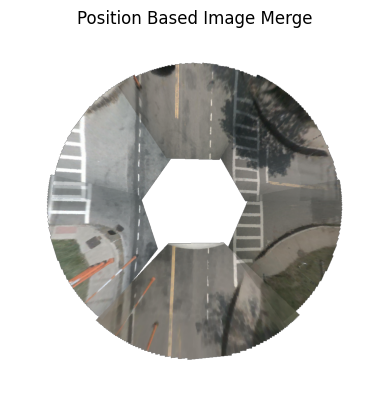

In [109]:
bev = position_based_stitch_bev_images(bev_results=bev_results)
plt.imshow(bev)
plt.title('Position Based Image Merge')
plt.savefig('images/bev_position_based.png', transparent=False)
plt.axis('off')

### Contour-Based Multi-Camera BEV Image Stitching via Overlap-Aware Distance Weighting
- For each BEV image, generate a valid mask using its alpha channel or provided binary mask.
- Identify overlapping regions between each pair of camera views and isolate their exclusive regions to compute boundary contours.
- For every overlapping pixel, compute its distance to both camera-exclusive contours and calculate a soft blending weight: pixels closer to a camera’s unique region boundary are weighted lower.
- Accumulate RGB values across all cameras using the computed weights, and compose the final stitched image with combined alpha visibility.

In [110]:
def contour_based_stitch_bev_images(bev_results):
    """
    Stitch multiple camera BEV images into a single RGBA frame.
    
    Args:
    - bev_results: dictionary containing all camera BEV results
    
    Returns:
    - stitched_bev: stitched BEV image
    """
    # Initialize variables
    first_cam = next(iter(bev_results))
    h, w = bev_results[first_cam]['bev'].shape[:2]
    stitched = np.zeros((h, w, 4), np.uint8) # final output
    weight_maps = {k: np.ones((h, w), np.float32) for k in bev_results} # per‑cam weights

    # Visibility mask per camera
    cam_masks = {}
    for cam, res in bev_results.items():
        bev = res['bev']
        if bev.shape[2] == 4: # RGBA supplied → use alpha
            cam_masks[cam] = (bev[:, :, 3] > 0).astype(np.uint8)
        else: # RGB supplied → fall back to provided mask or full‑frame
            cam_masks[cam] = res.get('mask', np.ones((h, w), bool)).astype(np.uint8)

    # Compute pair‑wise contour distance weights
    kernel = np.ones((5, 5), np.uint8) # small structuring element for closing
    eps = 1e-6 # avoids divide‑by‑zero at the contour
    cams = list(bev_results)

    for i in range(len(cams)):
        for j in range(i + 1, len(cams)):
            a, b = cams[i], cams[j]
            overlap = cam_masks[a] & cam_masks[b] # shared pixels
            if not np.any(overlap):
                continue # no overlap → skip

            # Extract pixels *unique* to each camera (needed to find contours)
            uniq_a = cv2.morphologyEx(cam_masks[a] - overlap, cv2.MORPH_CLOSE, kernel)
            uniq_b = cv2.morphologyEx(cam_masks[b] - overlap, cv2.MORPH_CLOSE, kernel)

            # Largest contour = boundary around exclusive region
            ca, _ = cv2.findContours(uniq_a, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cb, _ = cv2.findContours(uniq_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not ca or not cb:
                continue # one camera lacks exclusive area

            pa = max(ca, key=cv2.contourArea)
            pb = max(cb, key=cv2.contourArea)
            # Slight simplification for speed
            pa = cv2.approxPolyDP(pa, 0.01 * cv2.arcLength(pa, True), True)
            pb = cv2.approxPolyDP(pb, 0.01 * cv2.arcLength(pb, True), True)

            # Compute a weight for every overlapping pixel (could vectorise, kept simple for clarity)
            ys, xs = np.where(overlap)
            for y, x in zip(ys, xs):
                p = (float(x), float(y))
                d_a = max(abs(cv2.pointPolygonTest(pa, p, True)), eps)
                d_b = max(abs(cv2.pointPolygonTest(pb, p, True)), eps)

                w_a = d_b**2 / (d_a**2 + d_b**2) # camera a weight
                w_b = 1.0 - w_a # camera b weight

                # Keep the *smallest* weight encountered (pixel might be in more than one pair)
                weight_maps[a][y, x] = min(weight_maps[a][y, x], w_a)
                weight_maps[b][y, x] = min(weight_maps[b][y, x], w_b)

    # Accumulate weighted RGB & combined alpha
    rgb_acc = np.zeros((h, w, 3), np.float32)
    alpha = np.zeros((h, w), bool)

    for cam, res in bev_results.items():
        bev = res['bev']
        if bev.shape[2] == 3: # add full‑opacity alpha if absent
            bev = np.dstack([bev, np.full((h, w), 255, bev.dtype)])
        rgb_acc += bev[:, :, :3].astype(np.float32) * weight_maps[cam][:, :, None]
        alpha |= bev[:, :, 3] > 0

    # Compose final RGBA frame
    stitched[:, :, :3] = np.clip(rgb_acc, 0, 255).astype(np.uint8)
    stitched[:, :, 3] = alpha.astype(np.uint8) * 255
    return stitched

(-0.5, 999.5, 999.5, -0.5)

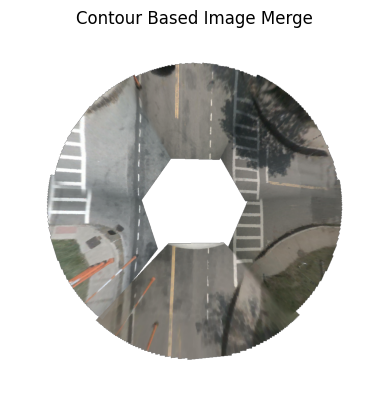

In [111]:
bev = contour_based_stitch_bev_images(bev_results=bev_results)
plt.imshow(bev)
plt.title('Contour Based Image Merge')
plt.savefig('images/bev_contour_based.png', transparent=False)
plt.axis('off')

### LAB-Based Brightness Equalization for Stitched BEV Images Using Soft CLAHE
- Convert the RGB channels of the stitched BEV image to the LAB color space to isolate the luminance (L) channel from chromatic information.
- Apply CLAHE with a reduced `clipLimit` to softly enhance local brightness while avoiding over-sharpened contrast.
- Recombine the enhanced L-channel with the original A and B channels and convert the image back to RGB.
- Merge the adjusted RGB data with the original alpha mask to retain transparency and produce the final RGBA image.

In [112]:
def brightness_balance(stitched_bev_rgba):
    """
    Soft brightness/contrast adjustment using CLAHE with mild parameters.

    Args:
        stitched_bev_rgba (np.ndarray): Input RGBA image

    Returns:
        np.ndarray: Brightness-balanced RGBA image
    """
    if stitched_bev_rgba is None or stitched_bev_rgba.shape[2] != 4:
        return stitched_bev_rgba

    # Separate RGB and Alpha
    rgb = stitched_bev_rgba[:, :, :3]
    alpha = stitched_bev_rgba[:, :, 3]

    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply mild CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge and convert back to RGB
    limg = cv2.merge((cl, a, b))
    adjusted_rgb = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Combine with alpha
    adjusted_bev_rgba = np.dstack((adjusted_rgb, alpha))

    return adjusted_bev_rgba

(-0.5, 999.5, 999.5, -0.5)

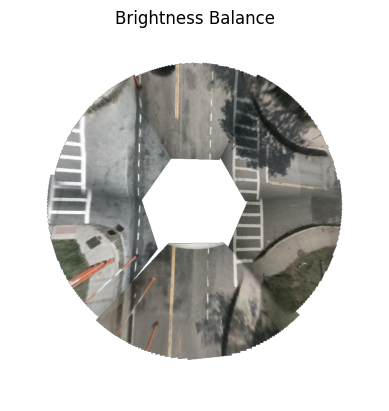

In [113]:
bev_brightness_balanced = brightness_balance(bev)
plt.imshow(bev_brightness_balanced)
plt.title('Brightness Balance')
plt.savefig('images/bev_brightness_balanced.png', transparent=False)
plt.axis('off')

### Visualize final BEV

In [123]:
def visualize_multicam_bev(bev_results, stitched_bev, flag_save=False, image_path='images/BEV.png'):
    """
    Visualize ONLY the final stitched multicamera BEV result.
    Includes detection results if available.
    
    Args:
    - bev_results: dictionary containing all camera BEV results (used for detections)
    - stitched_bev: stitched BEV image (required)
    - save_flag: whether to save image
    """
    # Set color map for detection results
    color_map = {
        'person': (255, 0, 0, 255),   # Red
        'car': (0, 255, 0, 255),      # Green
        'truck': (0, 0, 255, 255),    # Blue
        'bus': (255, 255, 0, 255),    # Yellow
        'motorcycle': (255, 0, 255, 255), # Magenta
        'bicycle': (0, 255, 255, 255),    # Cyan
    }

    # Prepare image to draw on (start with stitched)
    stitched_display = stitched_bev.copy()

    # Collect all detection results
    all_detections = []
    for _, result in bev_results.items():
        if 'detection_points' in result and result['detection_points']:
            all_detections.extend(result['detection_points'])

    # If detections exist, draw them and update title/filename
    show_legend = False
    if all_detections:
        title = 'Stitched BEV with Object Detection'
        show_legend = True
        for box in all_detections:
            x, y = box['bev_x'], box['bev_y']
            cls = box['class']
            color = color_map.get(cls)
            cv2.circle(stitched_display, (x, y), 5, color, -1)
            # Add class label
            label_text = f"{cls}"
            cv2.putText(stitched_display, label_text, (x + 7, y - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color[:3], 1, cv2.LINE_AA)
            # Add distance if available
            if 'distance' in box:
                distance = box['distance']
                dist_text = f"{distance:.1f}m"
                cv2.putText(stitched_display, dist_text, (x + 7, y + 7), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, color[:3], 1, cv2.LINE_AA)

    # Create the figure and plot the final image
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(stitched_display)
    plt.axis('off')
    plt.axis('off')

    # Add legend if detections were shown
    if show_legend:
        legend_elements = []
        plotted_classes = set()
        # Create legend handles dynamically based on actual detections
        for box in all_detections:
             cls = box['class']
             if cls not in plotted_classes:
                 color = color_map.get(cls)
                 # Use plot for legend handle creation
                 handle, = plt.plot([], [], 'o', color=[c/255 for c in color[:3]], label=cls, markersize=5)
                 legend_elements.append(handle)
                 plotted_classes.add(cls)
        if legend_elements: # Only show legend if there are elements
             plt.legend(handles=legend_elements, loc='upper right')
             
    if flag_save:
        plt.savefig(image_path, transparent=False)
    plt.show()







0: 384x640 1 car, 1 truck, 40.7ms
Speed: 1.1ms preprocess, 40.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 cars, 41.3ms
0: 384x640 9 cars, 42.6ms
Speed: 1.0ms preprocess, 41.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Speed: 1.2ms preprocess, 42.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 (no detections), 44.4ms
Speed: 1.1ms preprocess, 44.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 4 cars, 1 bus, 46.7ms
Speed: 1.4ms preprocess, 46.7ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 cars, 45.2ms
Speed: 1.1ms preprocess, 45.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


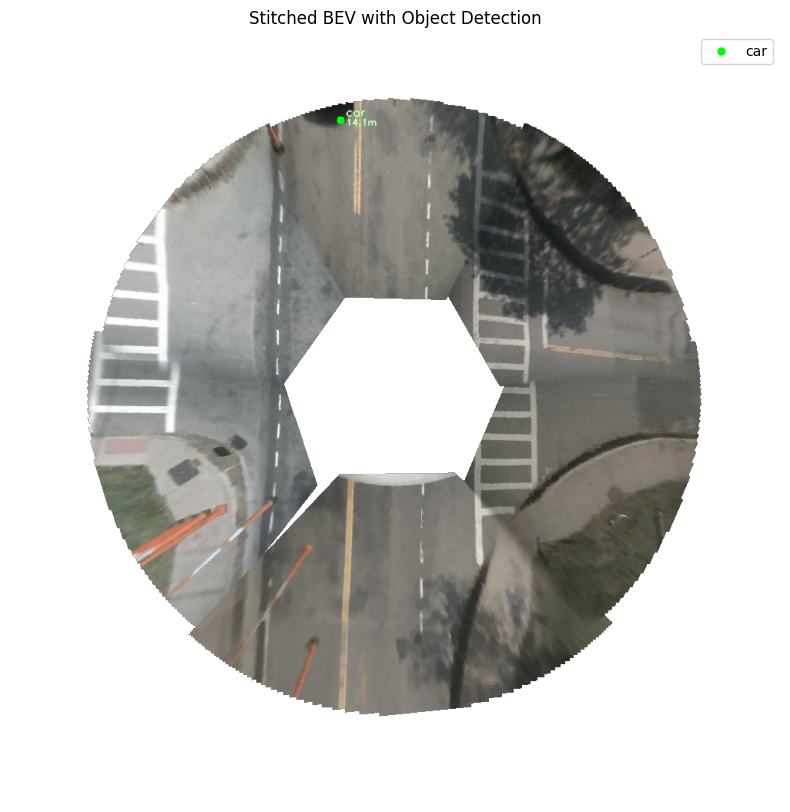

In [130]:
bev_results = process_all_cameras_parallel(nusc.sample[159]['token'])
bev = contour_based_stitch_bev_images(bev_results=bev_results)
visualize_multicam_bev(bev_results, bev, flag_save=True)







0: 384x640 3 persons, 4 cars, 40.4ms
Speed: 2.6ms preprocess, 40.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 cars, 43.6ms
Speed: 3.0ms preprocess, 43.6ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 (no detections), 46.1ms
Speed: 2.4ms preprocess, 46.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 1 car, 46.3ms
Speed: 1.9ms preprocess, 46.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 trucks, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 4 persons, 3 cars, 48.7ms
Speed: 2.5ms preprocess, 48.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


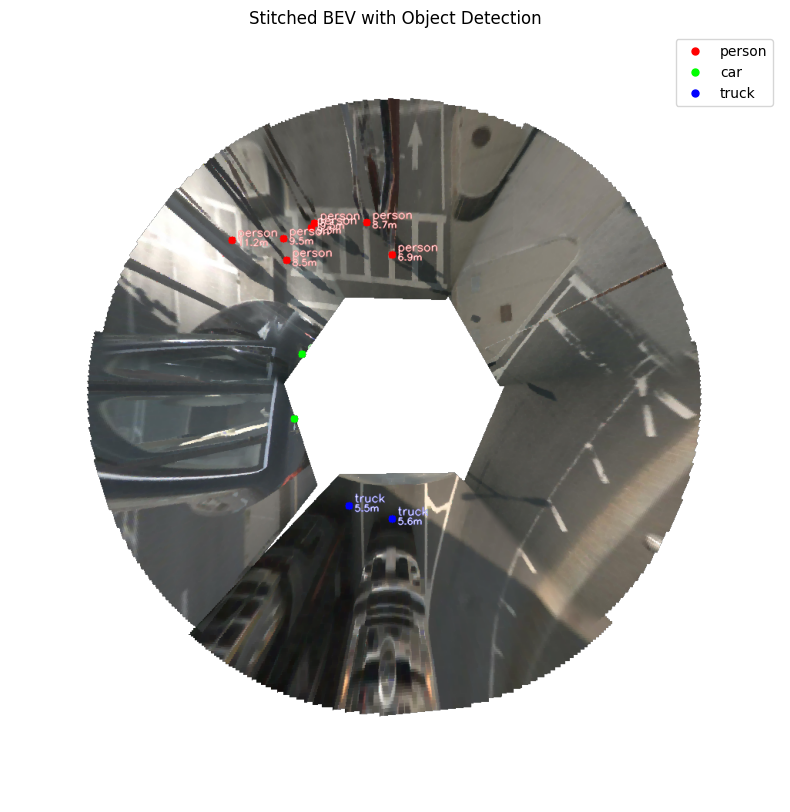

In [125]:
bev_results = process_all_cameras_parallel(nusc.sample[100]['token'])
bev = contour_based_stitch_bev_images(bev_results=bev_results)
visualize_multicam_bev(bev_results, bev, flag_save=True)

# Generate video

In [116]:
! python generate_bev_video.py --output 'bev_video_detection.mp4' --wd

In [117]:
from IPython.display import Image, display

display(Image(filename="videos/bev_video_detection.gif"))

# Unsolved Problem
When performing object detection, a single vehicle may appear in multiple camera views simultaneously, resulting in the same vehicle being detected multiple times. In the final bird's-eye view, this leads to multiple detection markers for the same object.

# Reference Projects
[surround-view-system-introduction](https://github.com/hynpu/surround-view-system-introduction/blob/master/doc/en.md)

[nuScenes Dataset](https://github.com/nutonomy/nuscenes-devkit)

# AI Usage
The AI ​​model used is Gemini 2.5
1. For the back-projection calculation function, I used AI to convert the version I wrote that uses CPU calculations into a version that uses torch to support cuda acceleration.(In the backward_projection.py file, create_bev_view_cpu_oldversion → create_bev_view)
2. Use AI to assist in the design and completion of contour_based_stitch_bev_images image fusion method.
3. Use AI to solve the audio track and video compatibility problems encountered in generate_bev_video.(cannot import notebook)
4. Use AI to adjust comments and improve code readability.
5. Use AI to help solve bugs during development.